In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import pickle 


### Get Data


- Abnormal Data Class = 1
- Normal Data Class = 0


In [2]:
#reading csv file
df = pd.read_csv("Datasets/fan_0db.csv")
df.shape

(5550, 16)

In [3]:
df.head()

,file_name,y_min,y_max,y_mean,y_std,zcr_mean,zcr_min,zcr_max,spec_cent_min,spec_cent_mean,rms_mean,amp_mean,amp_min,melspec_mean,melspec_std,class
0,Audio_Files/0dB_fan/id_00/abnormal/00000059.wav,-0.032230,0.029817,-6.926849e-07,0.009295,0.031904,0.016113,0.054688,1056.230929,1195.770358,0.009263,0.020296,0.012419,0.020323,0.119019,1
1,Audio_Files/0dB_fan/id_00/abnormal/00000071.wav,-0.034450,0.028665,-6.027881e-07,0.009493,0.021894,0.009766,0.034668,703.965079,800.327823,0.009442,0.020580,0.013375,0.021241,0.128594,1
2,Audio_Files/0dB_fan/id_00/abnormal/00000065.wav,-0.034897,0.028662,5.634240e-06,0.009543,0.027962,0.010742,0.047852,871.776362,998.865525,0.009508,0.020938,0.015119,0.021519,0.125431,1
3,Audio_Files/0dB_fan/id_00/abnormal/00000273.wav,-0.024785,0.026773,5.817374e-07,0.006059,0.057802,0.017578,0.087402,1112.632569,1419.440256,0.006014,0.016007,0.010261,0.008460,0.032597,1
4,Audio_Files/0dB_fan/id_00/abnormal/00000267.wav,-0.034780,0.037046,1.282572e-06,0.004874,0.049731,0.016602,0.279785,771.766407,1154.008254,0.004715,0.012308,0.005732,0.005148,0.024881,1


In [4]:
# drop unnecessary data
df = df.drop(columns = 'file_name')


X = df.drop(columns = 'class')
y = df['class']


In [5]:
count = df['class'].value_counts()
count

0    4075
1    1475
Name: class, dtype: int64

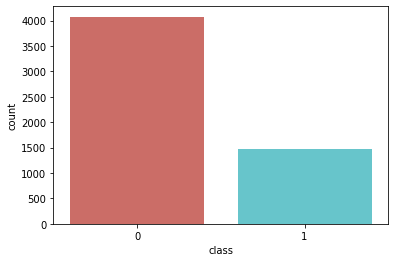

In [6]:
sns.countplot(x='class',data= df, palette= 'hls')
plt.show()

### Split Data

In [7]:
# Split dataset train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Standard Scaler

- Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


### Decision Tree

In [9]:
print(f'training set size: {X_train.shape[0]} samples \ntest set size: {X_test.shape[0]} samples')


classifier = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3) # optimize the accuracy 

classifier.fit(X_train,y_train)

training set size: 4440 samples 
test set size: 1110 samples


DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [10]:
# Predict
y_pred = classifier.predict(X_test)


In [11]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [12]:
#Evaluation of the model

print('Test accuracy for DT is:',metrics.accuracy_score(y_test,y_pred)*100)

Test accuracy for DT is: 81.89189189189189


In [13]:
print('\nConfusion matrix:\n',metrics.confusion_matrix(y_test,y_pred))


Confusion matrix:
 [[797   0]
 [201 112]]


In [14]:
print('\n Classification Report: \n',metrics.classification_report(y_test,y_pred))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       797
           1       1.00      0.36      0.53       313

    accuracy                           0.82      1110
   macro avg       0.90      0.68      0.71      1110
weighted avg       0.86      0.82      0.79      1110



### ROC CURVE

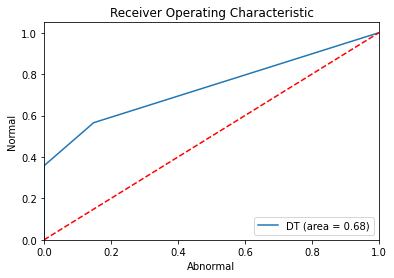

In [15]:
logit_roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test,classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='DT (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Abnormal')
plt.ylabel('Normal')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_DT')
plt.show()

### Cross Validation

In [16]:
accuracies = cross_val_score(estimator = classifier, X = X, y = y, cv=10)
AccuraciesMean = accuracies.mean()*100
StandardDeviation = accuracies.std()*100

print("%0.2f mean accuracy with a standard deviation of %0.2f" % (AccuraciesMean, StandardDeviation))


82.67 mean accuracy with a standard deviation of 9.15


In [17]:
accuracies

array([0.84324324, 0.81621622, 0.84864865, 0.73333333, 0.73513514,
       0.73513514, 0.73693694, 0.85585586, 0.96216216, 1.        ])

In [18]:
def check_overfitting(range_number):
    train_scores, test_scores = list(), list()
    values = [i for i in range(1, range_number)]
    for i in values:
        model = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3) # optimize the accuracy 
        model.fit(X_train, y_train)
        # train accuracy 
        x_pred = model.predict(X_train)
        train_acc = metrics.accuracy_score(y_train, x_pred)
        train_scores.append(train_acc)
        #test accuracy
        y_pred = model.predict(X_test)
        test_acc = metrics.accuracy_score(y_test, y_pred)
        test_scores.append(test_acc)
        print("{},    Train: {},   Test: {}".format(i, train_acc, test_acc))
        
    plt.plot(values, train_scores, '-o', label='Train')
    plt.plot(values, test_scores, '-o', label='Test')
    plt.legend()
    plt.show()
         

1,    Train: 0.8342342342342343,   Test: 0.8189189189189189
2,    Train: 0.8342342342342343,   Test: 0.8189189189189189
3,    Train: 0.8342342342342343,   Test: 0.8189189189189189
4,    Train: 0.8342342342342343,   Test: 0.8189189189189189
5,    Train: 0.8342342342342343,   Test: 0.8189189189189189
6,    Train: 0.8342342342342343,   Test: 0.8189189189189189
7,    Train: 0.8342342342342343,   Test: 0.8189189189189189
8,    Train: 0.8342342342342343,   Test: 0.8189189189189189
9,    Train: 0.8342342342342343,   Test: 0.8189189189189189


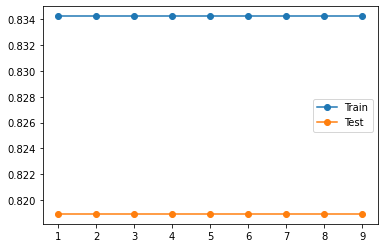

In [19]:
check_overfitting(10)

### Feature Selection

- Variance Threshold Feature Selection
- Univariate Selection using SelectKBest
- Recursive Feature Elimination or RFE
- SelectFromModel
- Sequential Feature Selection or SFS

### Create New Model With Reduces Features

In [20]:
X = df[['y_std', 'rms_mean', 'amp_mean', 'melspec_mean', 'spec_cent_mean']]
y = df['class']

### Split Data

In [21]:
# Split dataset train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


### Feature Scaling : Standard Scaler

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model

In [23]:
print(f'training set size: {X_train.shape[0]} samples \ntest set size: {X_test.shape[0]} samples')


classifier = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3) # optimize the accuracy 

classifier.fit(X_train,y_train)

training set size: 4440 samples 
test set size: 1110 samples


DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [24]:
# Predict
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

### Evaluation

In [25]:
print('Test accuracy for Decision Tree is:',metrics.accuracy_score(y_test,y_pred)*100)

Test accuracy for Decision Tree is: 83.15315315315316


In [26]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
print('\nConfusion matrix:\n',cnf_matrix)



Confusion matrix:
 [[814   2]
 [185 109]]


In [27]:
print('\n Classification Report: \n',metrics.classification_report(y_test,y_pred))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90       816
           1       0.98      0.37      0.54       294

    accuracy                           0.83      1110
   macro avg       0.90      0.68      0.72      1110
weighted avg       0.86      0.83      0.80      1110



1,    Train: 0.8315315315315316,   Test: 0.8315315315315316
2,    Train: 0.8315315315315316,   Test: 0.8315315315315316
3,    Train: 0.8315315315315316,   Test: 0.8315315315315316
4,    Train: 0.8315315315315316,   Test: 0.8315315315315316
5,    Train: 0.8315315315315316,   Test: 0.8315315315315316
6,    Train: 0.8315315315315316,   Test: 0.8315315315315316
7,    Train: 0.8315315315315316,   Test: 0.8315315315315316
8,    Train: 0.8315315315315316,   Test: 0.8315315315315316
9,    Train: 0.8315315315315316,   Test: 0.8315315315315316


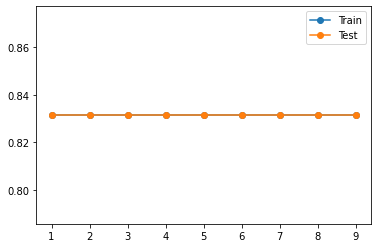

In [28]:
check_overfitting(10)

### Cross Validation

In [29]:
accuracies = cross_val_score(estimator = classifier, X = X, y = y, cv=10)
AccuraciesMean = accuracies.mean()*100
StandardDeviation = accuracies.std()*100

print("%0.2f mean accuracy with a standard deviation of %0.2f" % (AccuraciesMean, StandardDeviation))


83.06 mean accuracy with a standard deviation of 9.70


In [30]:
accuracies

array([0.84324324, 0.82342342, 0.84864865, 0.73333333, 0.73513514,
       0.73513514, 0.73513514, 0.85585586, 0.9963964 , 1.        ])

In [31]:
text_representation = tree.export_text(classifier)
print(text_representation)

|--- feature_2 <= -1.59
|   |--- feature_2 <= -1.71
|   |   |--- feature_3 <= -1.01
|   |   |   |--- class: 1
|   |   |--- feature_3 >  -1.01
|   |   |   |--- class: 1
|   |--- feature_2 >  -1.71
|   |   |--- feature_1 <= -0.58
|   |   |   |--- class: 1
|   |   |--- feature_1 >  -0.58
|   |   |   |--- class: 0
|--- feature_2 >  -1.59
|   |--- feature_3 <= 1.87
|   |   |--- feature_4 <= -0.76
|   |   |   |--- class: 0
|   |   |--- feature_4 >  -0.76
|   |   |   |--- class: 0
|   |--- feature_3 >  1.87
|   |   |--- class: 1



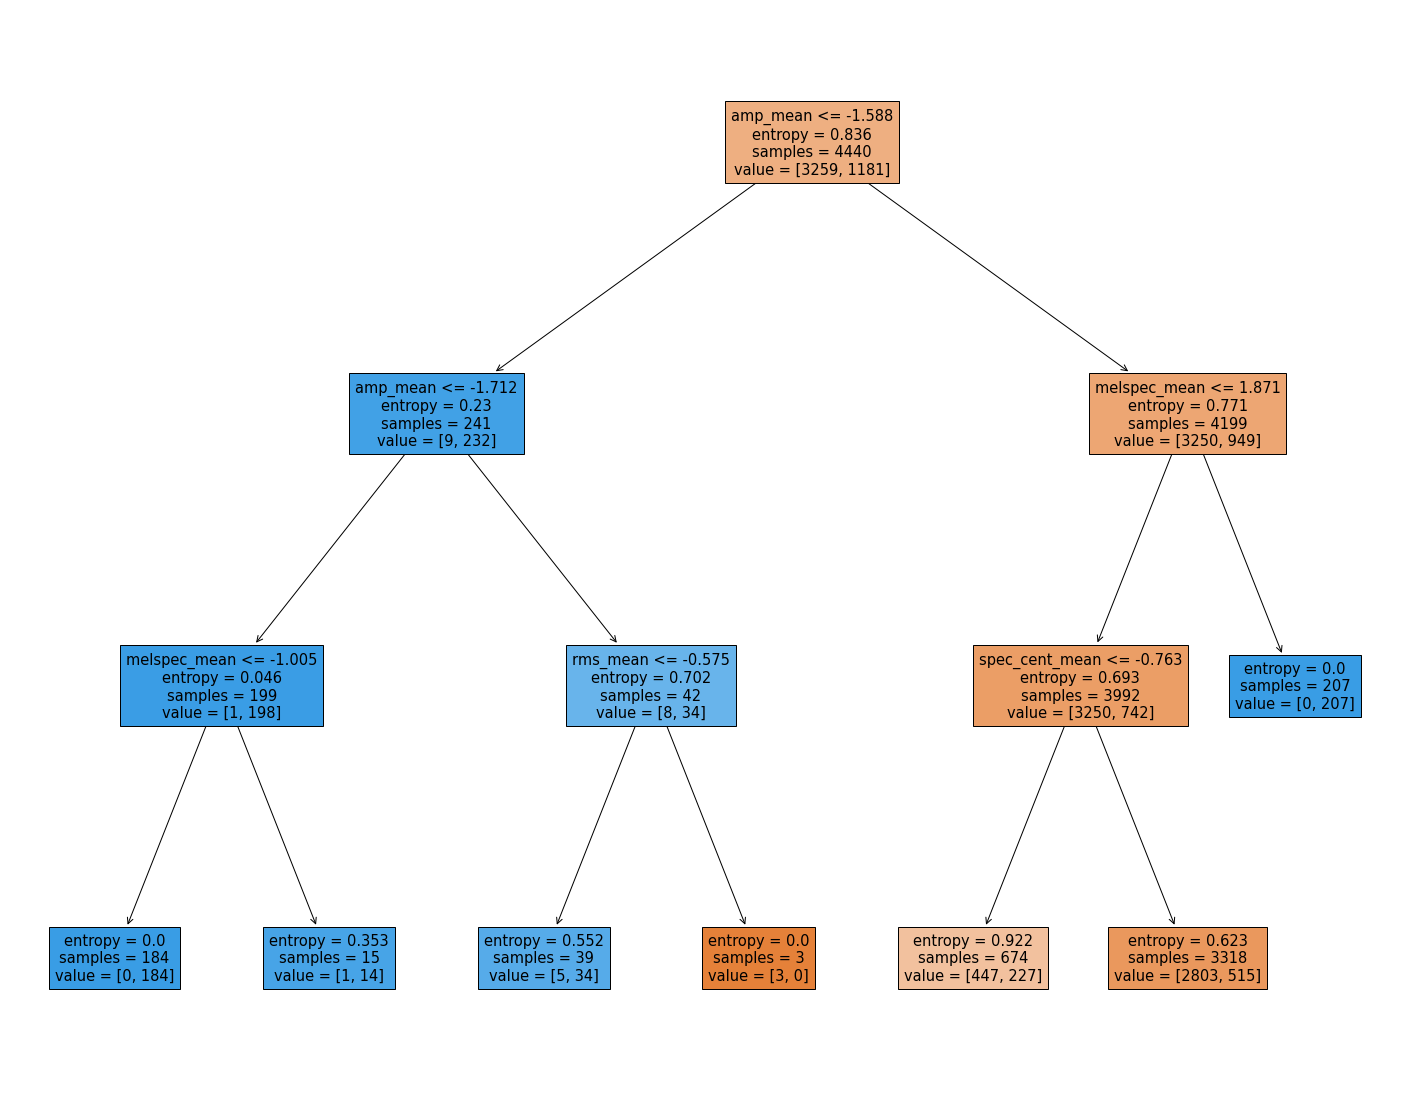

In [32]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classifier, feature_names=X.keys(), filled=True)

### Create a model


In [33]:
# save model
filename = 'fan_0db_dt.sav'
pickle.dump(classifier, open(filename, 'wb'))


In [34]:
# try model
rf_model = pickle.load(open(filename, 'rb'))


In [35]:
result = rf_model.predict(X_test)

In [36]:
result

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
...
# define the tree depths to evaluate
values = [i for i in range(1, 21)]